# LSTM for classification 


In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

from sklearn.feature_extraction.text import CountVectorizer
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense, Embedding, LSTM, SpatialDropout1D
from sklearn.model_selection import train_test_split
from keras.utils.np_utils import to_categorical
import re


Only keeping the necessary columns.

In [2]:
data = pd.read_csv('Sentiment_.csv')
# Keeping only the neccessary columns
data = data[['text','sentiment']]

Next, I am dropping the 'Neutral' sentiments as my goal was to only differentiate positive and negative tweets. After that, I am filtering the tweets so only valid texts and words remain.  Then, I define the number of max features as 2000 and use Tokenizer to vectorize and convert text into Sequences so the Network can deal with it as input.

In [3]:
data = data[data.sentiment != "Neutral"]
data['text'] = data['text'].apply(lambda x: x.lower())
data['text'] = data['text'].apply((lambda x: re.sub('[^a-zA-z0-9\s]','',x)))

print(data[ data['sentiment'] == 'Positive'].size)
print(data[ data['sentiment'] == 'Negative'].size)

for idx,row in data.iterrows():
    row[0] = row[0].replace('rt',' ')
    
max_features = 2000
tokenizer = Tokenizer(num_words=max_features, split=' ')
tokenizer.fit_on_texts(data['text'].values)
X = tokenizer.texts_to_sequences(data['text'].values)
X = pad_sequences(X)

4472
16986


Next, I compose the LSTM Network. Note that **embed_dim**, **lstm_out**, **batch_size**, **droupout_x** variables are hyperparameters, their values are somehow intuitive, can be and must be played with in order to achieve good results. Please also note that I am using softmax as activation function. The reason is that our Network is using categorical crossentropy, and softmax is just the right activation method for that.

In [4]:
embed_dim = 128
lstm_out = 196

model = Sequential()
model.add(Embedding(max_features, embed_dim,input_length = X.shape[1]))
#model.add(SpatialDropout1D(0.4))
model.add(LSTM(lstm_out, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(2,activation='softmax'))
model.compile(loss = 'categorical_crossentropy', optimizer='adam',metrics = ['accuracy'])
print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 28, 128)           256000    
                                                                 
 lstm (LSTM)                 (None, 196)               254800    
                                                                 
 dense (Dense)               (None, 2)                 394       
                                                                 
Total params: 511,194
Trainable params: 511,194
Non-trainable params: 0
_________________________________________________________________
None


Hereby I declare the train and test dataset.

In [5]:
Y = pd.get_dummies(data['sentiment']).values
X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size = 0.33, random_state = 42)
print(X_train.shape,Y_train.shape)
print(X_test.shape,Y_test.shape)

(7188, 28) (7188, 2)
(3541, 28) (3541, 2)


Here we train the Network. We should run much more than 7 epoch, but you can configure an Early Stopping to have the network to stop when loss is not improving.

In [15]:
batch_size = 32
model.fit(X_train, Y_train, epochs = 10, batch_size=batch_size, verbose = 2)

Epoch 1/10
225/225 - 31s - loss: 0.0921 - accuracy: 0.9627 - 31s/epoch - 139ms/step
Epoch 2/10
225/225 - 50s - loss: 0.0858 - accuracy: 0.9649 - 50s/epoch - 223ms/step
Epoch 3/10
225/225 - 49s - loss: 0.0947 - accuracy: 0.9638 - 49s/epoch - 216ms/step
Epoch 4/10
225/225 - 68s - loss: 0.0797 - accuracy: 0.9665 - 68s/epoch - 304ms/step
Epoch 5/10
225/225 - 64s - loss: 0.0738 - accuracy: 0.9677 - 64s/epoch - 286ms/step
Epoch 6/10
225/225 - 70s - loss: 0.0738 - accuracy: 0.9697 - 70s/epoch - 311ms/step
Epoch 7/10
225/225 - 56s - loss: 0.0732 - accuracy: 0.9693 - 56s/epoch - 248ms/step
Epoch 8/10
225/225 - 56s - loss: 0.0746 - accuracy: 0.9681 - 56s/epoch - 248ms/step
Epoch 9/10
225/225 - 48s - loss: 0.0720 - accuracy: 0.9695 - 48s/epoch - 215ms/step
Epoch 10/10
225/225 - 58s - loss: 0.0674 - accuracy: 0.9711 - 58s/epoch - 259ms/step


In [16]:

#since tf 2.6 and later 
predictions = model.predict(X_test)
predictions 

array([[3.5642827e-01, 6.4357179e-01],
       [1.0000000e+00, 5.2229410e-08],
       [1.0338276e-01, 8.9661723e-01],
       ...,
       [9.9772424e-01, 2.2757831e-03],
       [9.9999821e-01, 1.7795348e-06],
       [1.0000000e+00, 1.4094835e-08]], dtype=float32)

In [17]:
prediction_classes=np.argmax(predictions,axis=1)
prediction_classes

array([1, 0, 1, ..., 0, 0, 0], dtype=int64)

In [18]:
score,acc = model.evaluate(X_test, Y_test, verbose = 2, batch_size = batch_size)

print("acc: %.2f" % (acc))

111/111 - 5s - loss: 1.1626 - accuracy: 0.8215 - 5s/epoch - 44ms/step
acc: 0.82


In [19]:
from sklearn.metrics import confusion_matrix,classification_report

In [20]:
cf_matrix = confusion_matrix(Y_test.argmax(axis=1),prediction_classes)

<AxesSubplot:>

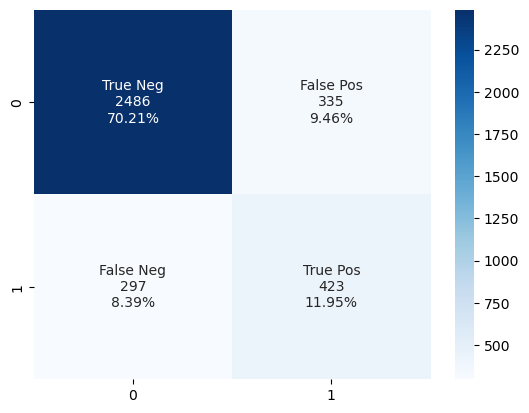

In [21]:
import seaborn as sns

group_names = ['True Neg','False Pos','False Neg','True Pos']
group_counts = ["{0:0.0f}".format(value) for value in
                cf_matrix.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in
                     cf_matrix.flatten()/np.sum(cf_matrix)]
labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)
sns.heatmap(cf_matrix, annot=labels, fmt='', cmap='Blues')

In [22]:
print(classification_report(Y_test.argmax(axis=1),prediction_classes))

              precision    recall  f1-score   support

           0       0.89      0.88      0.89      2821
           1       0.56      0.59      0.57       720

    accuracy                           0.82      3541
   macro avg       0.73      0.73      0.73      3541
weighted avg       0.83      0.82      0.82      3541



Let's try it in action

In [23]:
twt = ['Meetings: Because none of us is as dumb as all of us.']
#vectorizing the tweet by the pre-fitted tokenizer instance
twt = tokenizer.texts_to_sequences(twt)
#padding the tweet to have exactly the same shape as `embedding_2` input
twt = pad_sequences(twt, maxlen=28, dtype='int32', value=0)
print(twt)
sentiment = model.predict(twt,batch_size=1,verbose = 2)[0]
if(np.argmax(sentiment) == 0):
    print("negative")
elif (np.argmax(sentiment) == 1):
    print("positive")

[[   0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0  206  633    6  150    5   55 1055   55   46    6  150]]
1/1 - 0s - 228ms/epoch - 228ms/step
negative
